<a href="https://colab.research.google.com/github/tomonari-masada/course2022-sml/blob/main/12_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tree-based methodsによる住宅価格の予測

* 前に使ったCalifornia housing datasetを使う。

 * scikit-learnからロードできるバージョンは、前処理が済んだキレイなデータなので、ここでは使わない。

* データの取得や前処理の一部は、
[Aurélien Géron. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition.](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) の2章と同じ。

* 今回は、以下の解説を参考にします。
 * https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html
* 特に、`sklearn.pipeline.make_pipeline`を用いることで、コードを簡素化します。

In [41]:
import numpy as np
from scipy import stats, special
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

%config InlineBackend.figure_format = 'retina'

## 1) データを取得

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

（ここより上の詳細はフォローしなくてもいいいです。）

In [27]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 2) データを概観しつつ前処理

In [28]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* 数値データではない列が一つだけある



In [29]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

* 今回は、この数値データではない列を残す
 * pandasのget_dummiesを使う



In [30]:
housing_num = pd.get_dummies(housing, columns=['ocean_proximity'])

In [31]:
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


In [34]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   total_rooms                 20640 non-null  float64
 4   total_bedrooms              20433 non-null  float64
 5   population                  20640 non-null  float64
 6   households                  20640 non-null  float64
 7   median_income               20640 non-null  float64
 8   median_house_value          20640 non-null  float64
 9   ocean_proximity_<1H OCEAN   20640 non-null  uint8  
 10  ocean_proximity_INLAND      20640 non-null  uint8  
 11  ocean_proximity_ISLAND      20640 non-null  uint8  
 12  ocean_proximity_NEAR BAY    20640 non-null  uint8  
 13  ocean_proximity_NEAR OCEAN  206

* Non-Null Countが他より少ない列がある。
 * 後で欠測値を埋める前処理をすることにする。



* 説明変数と目的変数を分ける



In [35]:
X = housing_num.drop('median_house_value', axis=1)
y = housing_num["median_house_value"]

## 3) 評価実験のための準備

* 今回は交差検証をおこなうので、テストデータだけを切り分けておく。
 * 交差検証には`sklearn.model_selection.cross_val_score`を使う。

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 14196 to 15795
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   16512 non-null  float64
 1   latitude                    16512 non-null  float64
 2   housing_median_age          16512 non-null  float64
 3   total_rooms                 16512 non-null  float64
 4   total_bedrooms              16512 non-null  float64
 5   population                  16512 non-null  float64
 6   households                  16512 non-null  float64
 7   median_income               16512 non-null  float64
 8   ocean_proximity_<1H OCEAN   16512 non-null  uint8  
 9   ocean_proximity_INLAND      16512 non-null  uint8  
 10  ocean_proximity_ISLAND      16512 non-null  uint8  
 11  ocean_proximity_NEAR BAY    16512 non-null  uint8  
 12  ocean_proximity_NEAR OCEAN  16512 non-null  uint8  
dtypes: float64(8), uint8(5)
mem

In [37]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 20046 to 3665
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   4128 non-null   float64
 1   latitude                    4128 non-null   float64
 2   housing_median_age          4128 non-null   float64
 3   total_rooms                 4128 non-null   float64
 4   total_bedrooms              3921 non-null   float64
 5   population                  4128 non-null   float64
 6   households                  4128 non-null   float64
 7   median_income               4128 non-null   float64
 8   ocean_proximity_<1H OCEAN   4128 non-null   uint8  
 9   ocean_proximity_INLAND      4128 non-null   uint8  
 10  ocean_proximity_ISLAND      4128 non-null   uint8  
 11  ocean_proximity_NEAR BAY    4128 non-null   uint8  
 12  ocean_proximity_NEAR OCEAN  4128 non-null   uint8  
dtypes: float64(8), uint8(5)
memor

## 4) 前処理

* どのような前処理をおこなうかは、お任せします。

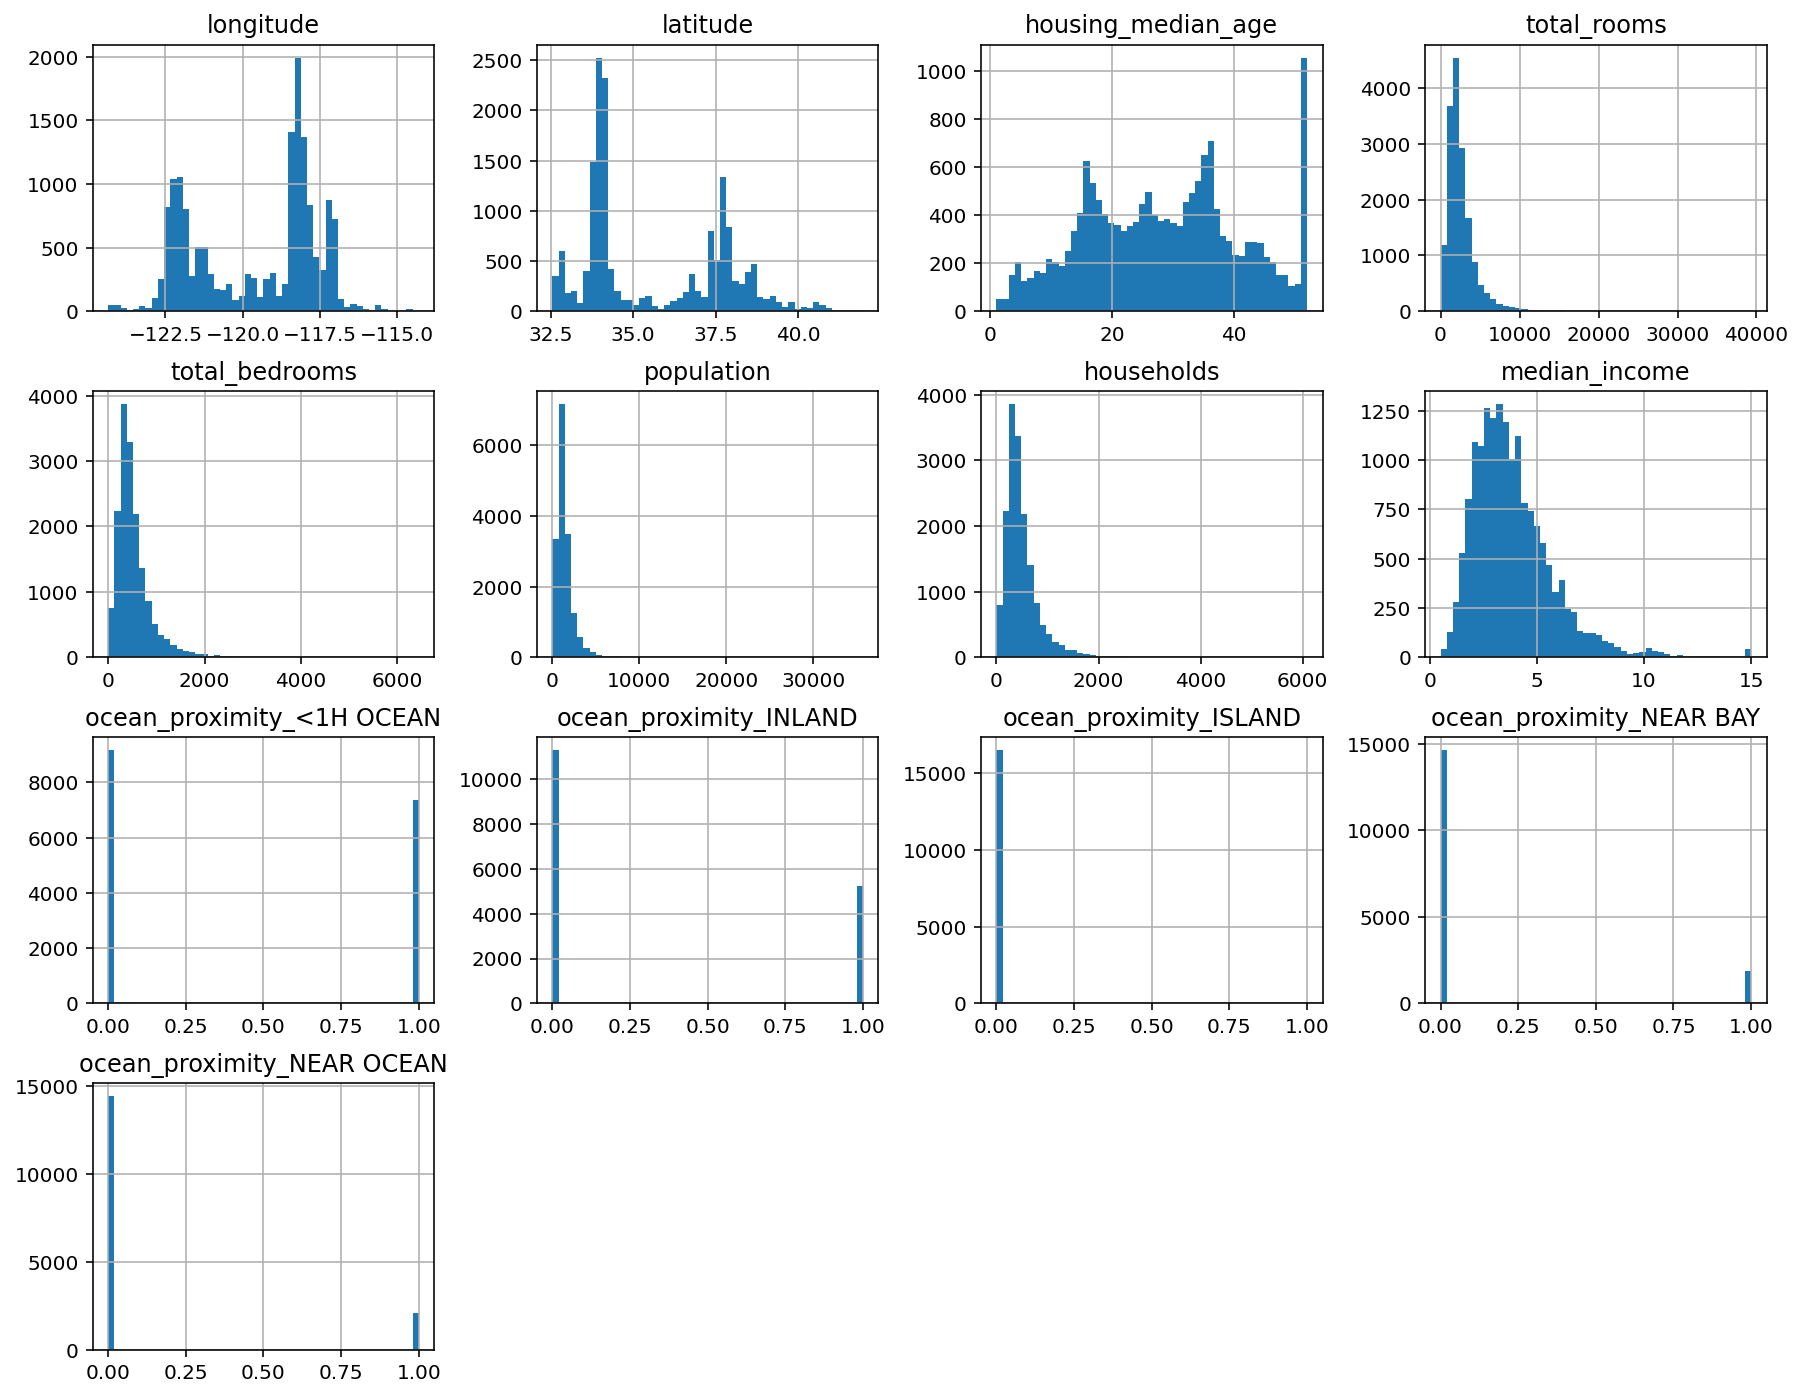

In [39]:
X_train.hist(bins=50, figsize=(15,12));

## 5) 決定木をチューニング

* 木の深さ（領域を何分割するか）をチューニングする。

* cross_val_scoreで使える評価尺度一覧をチェックする。
 * いずれも、「値が大きいほど良い」という評価尺度になっている。
 * 今回はRMSEで評価したいが、これは「値が小さいほど良い」という評価尺度である。
 * そこで、一覧の中にある'neg_root_mean_squared_error'に、マイナスをつけたものを、使う。
 * これで前の結果と比較できるようになる。



In [42]:
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

* 交差検証を、欠損値を埋めつつ実行するために、ヘルパ関数を定義しておく。

In [45]:
def get_scores(imputer, regressor, X_missing, y_missing, cv=10):
  estimator = make_pipeline(imputer, regressor)
  impute_scores = cross_val_score(
      estimator, X_missing, y_missing, scoring="neg_root_mean_squared_error", cv=cv
      )
  return impute_scores

* 10-fold cross validationを実施
 * 木の深さは3から20まで変える。
 * 評価尺度はRMSE。



In [46]:
for i in range(3, 16):
  reg = tree.DecisionTreeRegressor(max_depth=i, random_state=123)
  imp = SimpleImputer(missing_values=np.nan, strategy='median')
  scores = get_scores(imp, reg, X_train, y_train, cv=10)
  print(f'depth {i}: {- scores.mean():.2f}') 

depth 3: 75948.25
depth 4: 73040.54
depth 5: 70407.71
depth 6: 67318.11
depth 7: 65130.43
depth 8: 63293.94
depth 9: 61521.01
depth 10: 61986.72
depth 11: 62220.51
depth 12: 62862.20
depth 13: 63962.87
depth 14: 64910.72
depth 15: 64936.20


* 最適な木の深さを使って訓練データ全体で学習をやり直し、テストデータで評価。



In [48]:
reg = tree.DecisionTreeRegressor(max_depth=9, random_state=123)
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(X_train)
reg.fit(X_train, y_train)
y_test_pred = reg.predict(imp.transform(X_test))
print('test RMSE: {:.2f}'.format(mean_squared_error(y_test, y_test_pred, squared=False)))

test RMSE: 61479.02


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


* これが今回のベースラインです。
* この値を改善することを試みてください。

# 今日の課題

* RMSEによって評価される予測性能を、良くして下さい
* test setとそれ以外の部分の分割は、変えないでください
 * test set以外の部分をどう使うかは、自由です
 * 交差検証の方法は何でもよいです。
* 決定木ベースの手法やその系統の手法なら、何を使ってもいいです。
* test setでのRMSEによる評価は、最後に一回おこなうだけです

## A) XGBoostを使ってみる



In [49]:
import xgboost as xgb

* 10-fold cross validationを実施


In [50]:
for i in range(6, 14):
  reg = xgb.XGBRegressor(objective ='reg:squarederror', max_depth=i, random_state=123)
  imp = SimpleImputer(missing_values=np.nan, strategy='median')
  scores = get_scores(imp, reg, X_train, y_train, cv=10)
  print(f'depth {i}: {- scores.mean():.2f}') 

depth 6: 48317.62
depth 7: 47406.13
depth 8: 47110.58
depth 9: 46873.51
depth 10: 47185.97
depth 11: 47251.26
depth 12: 47581.24
depth 13: 48016.46


* 最適な木の深さを使って訓練データ全体で学習をやり直し、テストデータで評価。



In [ ]:
# 各自、実践してください。

## B) CatBoostを使ってみる

In [51]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [52]:
from catboost import CatBoostRegressor

In [53]:
for i in range(6, 14):
  reg = CatBoostRegressor(iterations=200, depth=i, random_seed=123, logging_level='Silent')
  imp = SimpleImputer(missing_values=np.nan, strategy='median')
  scores = get_scores(imp, reg, X_train, y_train, cv=10)
  print(f'depth {i}: {- scores.mean():.2f}') 

depth 6: 47166.30
depth 7: 46547.52
depth 8: 46626.42
depth 9: 46442.12
depth 10: 46679.55
depth 11: 46819.78
depth 12: 47081.90
depth 13: 47319.67


* 最適な木の深さを使って訓練データ全体で学習をやり直し、テストデータで評価。

In [ ]:
# 各自、実践してください。
